In [34]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import requests
import scipy as sp
from scipy.signal import spectrogram, lfilter, freqz, butter, buttord, argrelextrema, convolve, tf2zpk
from scipy.io.wavfile import write as writewav
from math import sqrt


In [62]:
# rozdeli signál na rámce s dĺžkou L a krokom S
def strided_frames(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

# vytvori DFT maticu
def create_dft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( -2j * np.pi / N )
    W = np.power( omega, i * j ) / sqrt(N)
    return W

# vyráta maticové DFT
def matrix_dft(x):
    N = len(x)
    return np.matmul(create_dft_matrix(N), x)


## 4.1 Základy

Načítaj signál, vypíš dlžku vo vzorkoch a sekundách, vzorkovaciu frekvenciu, maximálnu a minimálnu hodnotu.
Vykresli graf signalu

Počet vzorkov signálu je 50893 na vzorkovacej frekvencii 16000 Hz
Dĺžka signálu 3.1808125 sekúnd
maximum:  0.15
minimum: -0.13


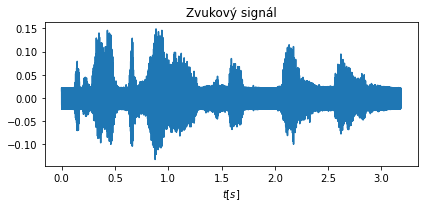

In [36]:
s, fs = sf.read('xhyros00.wav')
signal_size = len(s)
time = signal_size / fs

maximum = np.max(s)
minimum = np.min(s)

print(f'Počet vzorkov signálu je {signal_size} na vzorkovacej frekvencii {fs} Hz')
print(f'Dĺžka signálu {time} sekúnd')
print(f'maximum:  {maximum:.2f}\nminimum: {minimum:.2f}')


# plotting
t = np.arange(s.size) / fs

plt.figure(figsize=(6,3))
plt.plot(t, s)

plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signál')

plt.tight_layout()

## 4.2 Predspracovanie a rámce
Signál ustredni a normalizuj
Rozdel signál na rámce o dĺžke 1024 vzorkov s krokom 512 vzorkov

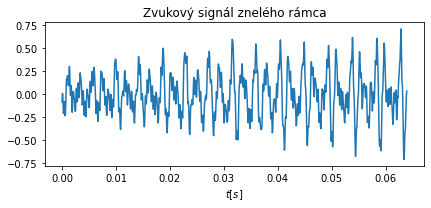

In [63]:
original = s

s -= np.mean(s)
s /= np.max(np.abs(s))  # normalizacia


frames = strided_frames(s, 1024, 512)

# znelá hláska nájdená na vzorku 33 664, v čase 00:00:02.104
'''
#my_sample = original[33664]
index = np.where(frames == my_sample)

#print(index)
print(frames[65, 384], frames[65, 385])
frames.shape
'''


# zvolený rámec má index 25
f = frames[25]
f2 = f


# plotting
t = np.arange(f.size) / fs

plt.figure(figsize=(6,3))
plt.plot(t, f)

plt.gca().set_xlabel('$t [s]$')
plt.gca().set_title('Zvukový signál znelého rámca')

plt.tight_layout()

## 4.3 Maticová DFT 
Rámec transformovaný cez maticové DFT a vykreslený jeho modul

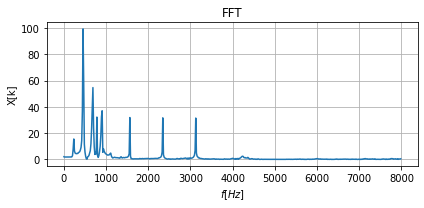

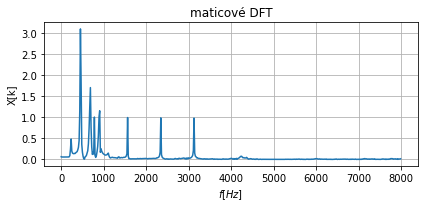

In [38]:
X = matrix_dft(f2) # moje dft
Xb = np.fft.fft(f) # knihovne dft

x = np.arange(0, fs/2, fs/1024)
y = np.abs(Xb[:512])


# plotting built-in fft

plt.figure(figsize=(6,3))
plt.grid(True)
plt.plot(x, y)

plt.gca().set_xlabel('$f[Hz]$')
plt.gca().set_ylabel('X[k]')
plt.gca().set_title('FFT')

plt.tight_layout()


# -----------------------

# ploting my matrix DFT
y = np.abs(X[:512])


plt.figure(figsize=(6,3))
plt.grid(True)
plt.plot(x, y)

plt.gca().set_xlabel('$f[Hz]$')
plt.gca().set_ylabel('X[k]')
plt.gca().set_title('maticové DFT')

plt.tight_layout()



## 4.4 Spektrogram
Logaritmický výkonový spektrogram vypočítaný a zobrazený pre celý signál

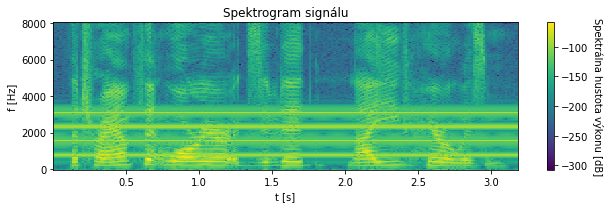

In [51]:
# DFT every frame
frames_transformed = matrix_dft(frames)

# creating spectrogram using scipys built in function
f, t, sgr = spectrogram(s, fs)

# process DFT coefficients as P[k] = 10 * log10(|X[k]|^2)
sgr_log = 10 * np.log10(np.power(np.abs(sgr), 2))

# plotting
plt.figure(figsize=(9,3))
plt.pcolormesh(t,f,sgr_log)
plt.gca().set_xlabel('t [s]')
plt.gca().set_ylabel('f [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektrálna hustota výkonu [dB]', rotation=270, labelpad=15)
plt.gca().set_title('Spektrogram signálu')
plt.tight_layout()

plt.savefig("sgr.png")


## 4.5 Hladanie rušivých frekvencií
Hladanie rušivých frekvencií

V module DFT z 4.3 je rozdiel medzi dvoma indexami Fs/1024 = 15.625 Hz

- f2 sa nachádza v rámci medzi indexami ( 64, 128)
- f3 sa nachádza v rámci medzi indexami (128, 160)
- f4 sa nachádza v rámci medzi indexami (192, 250)



In [65]:
# na hladanie využijem modul DFT z 4.3

# konvertuje index na frekvenciu
def to_freqw(index):
    return index * 15.625



#f1_i = np.argmax(X[32:64]) + 32
f2_i = np.argmax(X[64:128]) + 64
f3_i = np.argmax(X[128:160]) + 128
f4_i = np.argmax(X[192:250]) + 192


# vráti pole lokálnych extrémov
f1_i = np.array(argrelextrema(X[0:64], np.greater)) + 0
# z grafu v 4.3 vieme odčítať, že rušivá frekvencia f1 má 4-tú najvyššiu hodnotu v intervale (0 - 1000 Hz)
#print(f1_i)
#print((np.abs(X[f1_i])))
#print(np.sort(np.abs(X[f1_i])))
# 4-tá najvyššia hodnota je 0.25413257 a má index 50

f1_i = 50

f1 = to_freqw(f1_i)
f2 = to_freqw(f2_i)
f3 = to_freqw(f3_i)
f4 = to_freqw(f4_i)

print(f'Rušivé frekvencie sa nachádzajú na indexoch: {f1_i, f2_i, f3_i, f4_i}')
print(f'Z toho frakvencie: {f1, f2, f3, f4} Hz')



Rušivé frekvencie sa nachádzajú na indexoch: (50, 99, 150, 199)
Z toho frakvencie: (781.25, 1546.875, 2343.75, 3109.375) Hz


## 4.6 Generovanie signálu

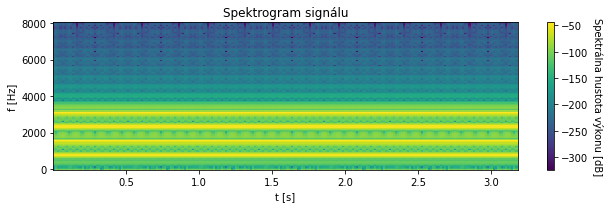

In [66]:
frequencies_list = np.array([f1, f2, f3, f4])
time = np.arange(0, signal_size)/fs
signal = np.zeros(signal_size)

# generovanie signálu
for f in frequencies_list:
      signal += np.cos(2*np.pi*f*time)
        
# vytvaranie spektrogramu vstvanou fciou
f, t, sgr = spectrogram(signal, fs)

# process DFT coefficients as P[k] = log10(|X[k]|^2)
sgr_log = 10 * np.log10(np.power(np.abs(sgr), 2))

# plotting
plt.figure(figsize=(9,3))
plt.pcolormesh(t,f,sgr_log)
plt.gca().set_xlabel('t [s]')
plt.gca().set_ylabel('f [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektrálna hustota výkonu [dB]', rotation=270, labelpad=15)
plt.gca().set_title('Spektrogram signálu')
plt.tight_layout()

writewav('4cos.wav', fs, signal)
plt.savefig("sgr2.png")

## 4.7 Návrh filtrov
Navrhni filtre type pásmová zádrž filtrujúce rušivé frekvencie

In [67]:
np.set_printoptions(precision=3)
Z = [] # nuly
P = [] # poly
K = []
B = [] # b koeficienty
A = [] # a koeficienty

# vytvaranie filtrov
for f1 in frequencies_list:
    N, Wn = buttord([f1 - 50, f1 + 50], [f1 - 15, f1 + 15], 3, 40, fs=fs)
    b, a = butter(N, Wn, btype='bandstop', fs=fs)
    z, p, k = butter(N, Wn, btype='bandstop', fs=fs, output='zpk')
    #print(N, Wn)
    #print(f'{b}\n{a}\n')
    #print(f'{z}\n{z}\n{k}\n')
    Z.append(z)
    P.append(p)
    K.append(k)
    B.append(b)
    A.append(a)


A, B = np.array(A), np.array(B)
print(A)
print(B)

[[  1.     -7.531  25.172 -48.738  59.769 -47.537  23.947  -6.988   0.905]
 [  1.     -6.486  19.674 -36.022  43.375 -35.121  18.703  -6.011   0.904]
 [  1.     -4.783  12.476 -20.822  24.466 -20.298  11.856  -4.431   0.903]
 [  1.     -2.706   6.645  -9.152  11.263  -8.921   6.314  -2.507   0.903]]
[[  0.951  -7.255  24.555 -48.142  59.78  -48.142  24.555  -7.255   0.951]
 [  0.951  -6.245  19.185 -35.576  43.384 -35.576  19.185  -6.245   0.951]
 [  0.95   -4.604  12.164 -20.563  24.472 -20.563  12.164  -4.604   0.95 ]
 [  0.95   -2.605   6.478  -9.038  11.266  -9.038   6.478  -2.605   0.95 ]]


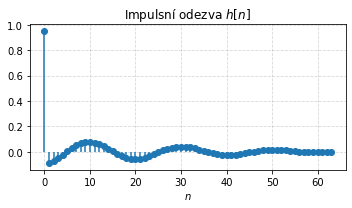

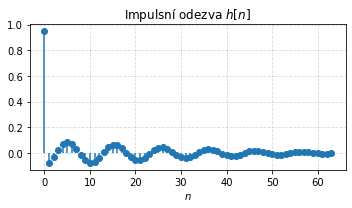

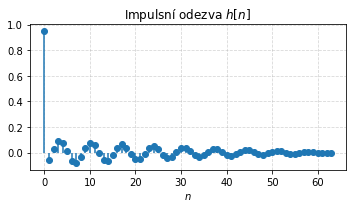

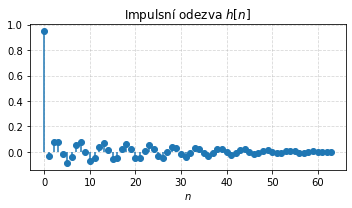

In [68]:
# Impulzne odozvy
i = 0
N_imp = 64
imp = [1, *np.zeros(N_imp-1)]
for a, b in zip(A, B):
    h = lfilter(b, a, imp)
    i += 1
    
    plt.figure(figsize=(5,3))
    plt.stem(np.arange(N_imp), h, basefmt=' ')
    plt.gca().set_xlabel('$n$')
    plt.gca().set_title('Impulsní odezva $h[n]$')

    plt.grid(alpha=0.5, linestyle='--')

    plt.tight_layout()
    #plt.savefig(f"imp{i}.svg")

## 4.8 Nuly a póly
Zobraz nuly a póly navrhnutých filtrov na komplexnej rovine

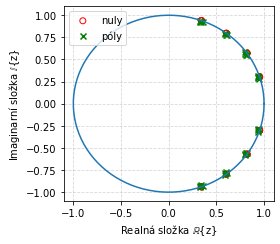

In [70]:
# nuly a poly plotting

plt.figure(figsize=(4,3.5))

# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))


plt.scatter(np.real(Z), np.imag(Z), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(P), np.imag(P), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

## 4.9 Frekvenčná charakteristika filtrov
Vyrátaj a zobraz frekvenčnú charakteristiku navrhnutých filtrov

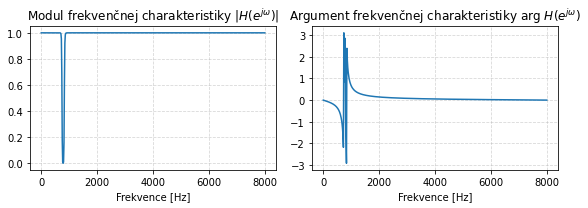

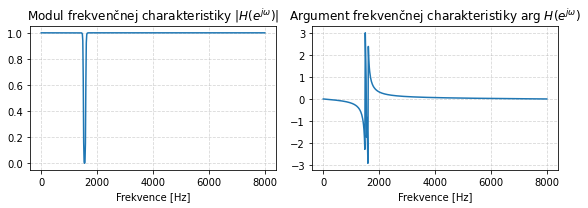

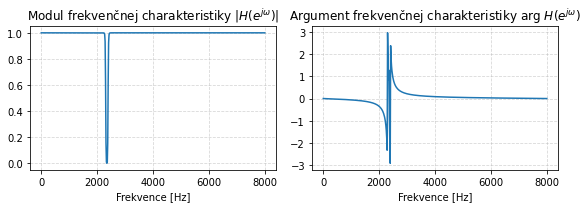

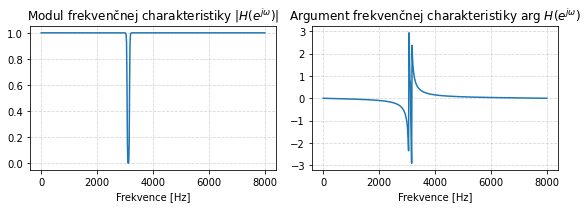

In [71]:
# plotting in for loop
for a, b in zip(A, B):
    w, H = freqz(b, a)
    _, ax = plt.subplots(1, 2, figsize=(8,3))

    ax[0].plot(w / 2 / np.pi * fs, np.abs(H))
    ax[0].set_xlabel('Frekvence [Hz]')
    ax[0].set_title('Modul frekvenčnej charakteristiky $|H(e^{j\omega})|$')

    ax[1].plot(w / 2 / np.pi * fs, np.angle(H))
    ax[1].set_xlabel('Frekvence [Hz]')
    ax[1].set_title('Argument frekvenčnej charakteristiky $\mathrm{arg}\ H(e^{j\omega})$')

    for ax1 in ax:
        ax1.grid(alpha=0.5, linestyle='--')

    plt.tight_layout()
    

## 4.10 Filtrovanie
Vyfiltruj vstupný signál

781.25


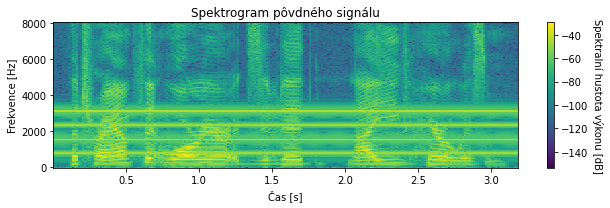

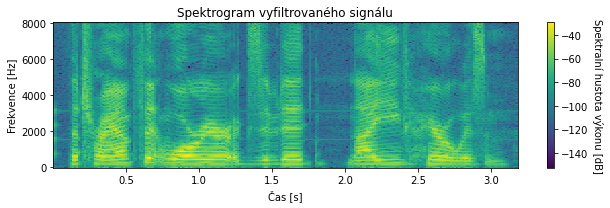

In [72]:
sf = s
sf = lfilter(B[0], A[0], sf)
sf = lfilter(B[1], A[1], sf)
sf = lfilter(B[2], A[2], sf)
sf = lfilter(B[3], A[3], sf)


writewav('clean_bandstop.wav', fs, sf)
print(frequencies_list[0])


f, t, sfgr = spectrogram(s, fs)
sfgr_log = 10 * np.log10(sfgr+1e-20)

plt.figure(figsize=(9,3))
plt.pcolormesh(t,f,sfgr_log)
plt.gca().set_title('Spektrogram pôvodného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

f, t, sfgr = spectrogram(sf, fs)
sfgr_log = 10 * np.log10(sfgr+1e-20)


plt.figure(figsize=(9,3))
plt.pcolormesh(t,f,sfgr_log)
plt.gca().set_title('Spektrogram vyfiltrovaného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig("filtered.png")
